In [68]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [69]:
word_vectors_dict = {}

In [70]:
with open('hw3/nmt-en-dec-512.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        splitted = line.split()
        word = splitted[0]
        vector = [float(el) for el in splitted[1:]]
        vector = np.array(vector)
        
        word_vectors_dict[word] = vector

In [71]:
word_vectors = np.array(list(word_vectors_dict.values()))

In [72]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto',
                  verbose=1,
                  init='random').fit_transform(word_vectors)
print(X_embedded.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.555s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.820730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.501343
[t-SNE] KL divergence after 1000 iterations: 2.506624
(5000, 2)


In [130]:
def plot_word_embeddings(embeddings, color="#C1E3B8", fontsize=12, annotation_freq=50, seed=1234):
    plt.figure(figsize=(15, 12))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=color)
    
    word_labels = list(word_vectors_dict.keys())
    
    np.random.seed(seed)
    indices = np.random.choice(embeddings.shape[0], annotation_freq, replace=False)  
    
    for i in indices:
        y = embeddings[i]
        word_label = word_labels[i]
        plt.annotate(word_label, (y[0], y[1]), fontsize=fontsize)

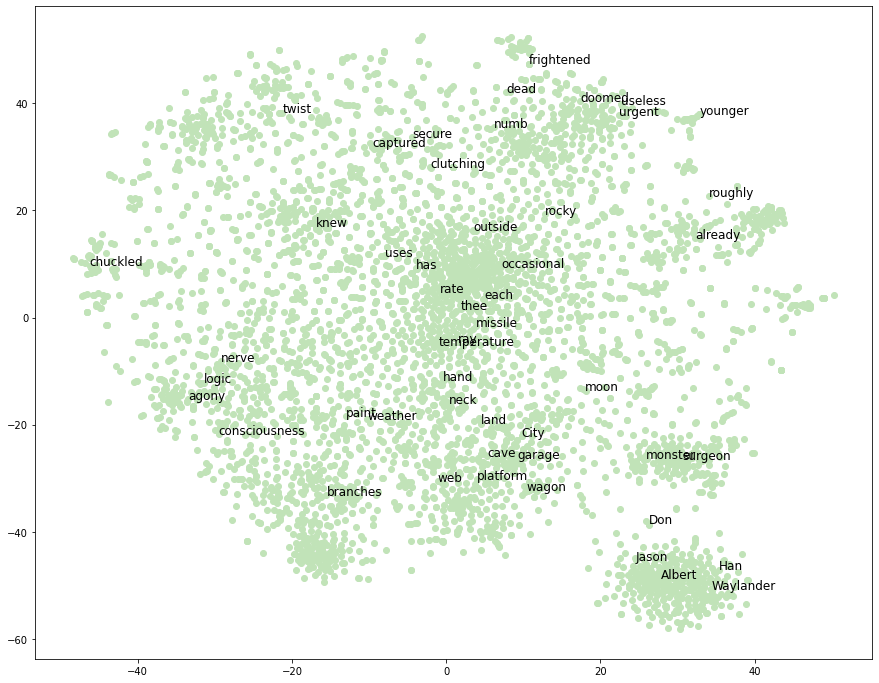

In [134]:
X = word_vectors
Y = X_embedded

plot_word_embeddings(Y)

# Task 2

Cluster the word vectors in the original 512-dimensional vector space using the methods of K-means, GaussianMixture, and Aglomerative clustering. Use the functions implemented in the `sklearn` library. Try different
number of clusters (3,5,10) and different linkage strategies (ward, single, complete). Visualize the clusters using different colors in T-SNE. Compute the Silhouette coeficients of the individual clusterings. Use `sklearn.metrics.silhouette_score`. What method is the best? What
methods failed? 

In [97]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph, NearestCentroid

from matplotlib import cm

In [98]:
def cluster(X, method, n_clusters, linkage_strategy=None):
    n_neighbors = 10
    
    clusterer = None
    if method == "K-means":
        clusterer = KMeans(
            n_clusters=n_clusters, 
            init='random',
            n_init=10, 
            max_iter=300, 
            tol=1e-04, 
            random_state=1
        )
    
    elif method == "Gaussian Mixture":
        clusterer = GaussianMixture(n_components=n_clusters, covariance_type="full")
        
    elif method == "Agglomerative Clustering":
        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=n_neighbors, include_self=False
        )
        # make connectivity symmetric
        #connectivity = 0.5 * (connectivity + connectivity.T)

        clusterer = AgglomerativeClustering(
            linkage=linkage_strategy,
            #affinity="cityblock",
            n_clusters=n_clusters,
            connectivity=connectivity,
        )
    else:
        print("ERROR")
    
    return clusterer, clusterer.fit_predict(X)

In [99]:
def plot_clusters(X, Y, n_clusters, method, sample_silhouette_values):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    silhouette_avg_str = "{:.5f}".format(silhouette_avg)
    ax1.set_title("The silhouette plot for the various clusters. Avg. sillhouette score: " + silhouette_avg_str)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    if method == "K-means":
        centers = clusterer.cluster_centers_
    elif method == "Gaussian Mixture":
        centers = clusterer.means_
    else:
        clf = NearestCentroid()
        clf.fit(X, Y)
        centers = clf.centroids_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    if method == "Agglomerative Clustering":
        subtitle = "Silhouette analysis for {} clustering using {} linkage strategy with n_clusters = {}".format(method, linkage_strategy, n_clusters)
    else:
        subtitle = "Silhouette analysis for {} clustering with n_clusters = {}".format(method, n_clusters)
    plt.suptitle(subtitle, fontsize=14, fontweight="bold")

For n_clusters =  3 the average silhouette_score is: 0.033828204158780115
For n_clusters =  5 the average silhouette_score is: 0.03459523947851218
For n_clusters = 10 the average silhouette_score is: 0.02732128801749716
For n_clusters =  3 the average silhouette_score is: 0.03389557574245622
For n_clusters =  5 the average silhouette_score is: 0.02953199213320831
For n_clusters = 10 the average silhouette_score is: 0.02984676676157239
For n_clusters =  3 (linkage strategy: ward) the average silhouette_score is: 0.02506865796935428
For n_clusters =  5 (linkage strategy: ward) the average silhouette_score is: 0.023781375782857883
For n_clusters = 10 (linkage strategy: ward) the average silhouette_score is: 0.00967672203769523
For n_clusters =  3 (linkage strategy: single) the average silhouette_score is: 0.3999057045328436
For n_clusters =  5 (linkage strategy: single) the average silhouette_score is: 0.3380703302647055
For n_clusters = 10 (linkage strategy: single) the average silhouett

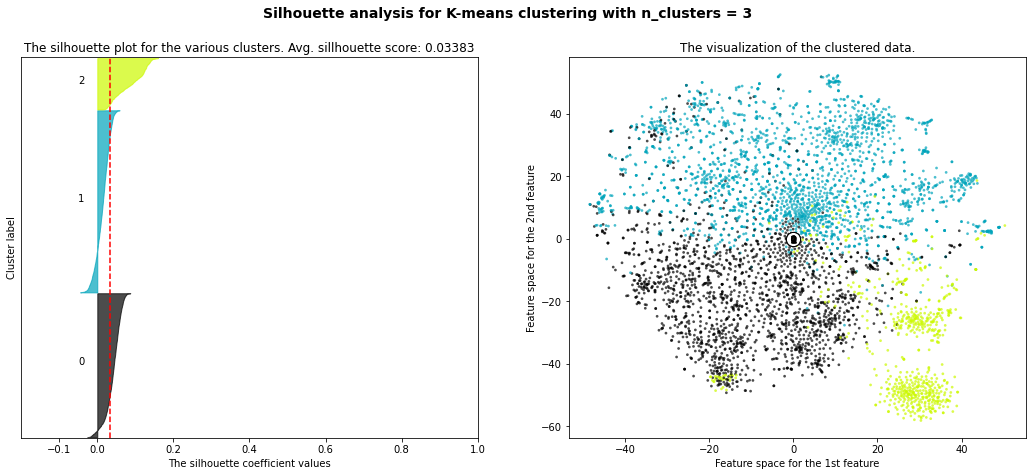

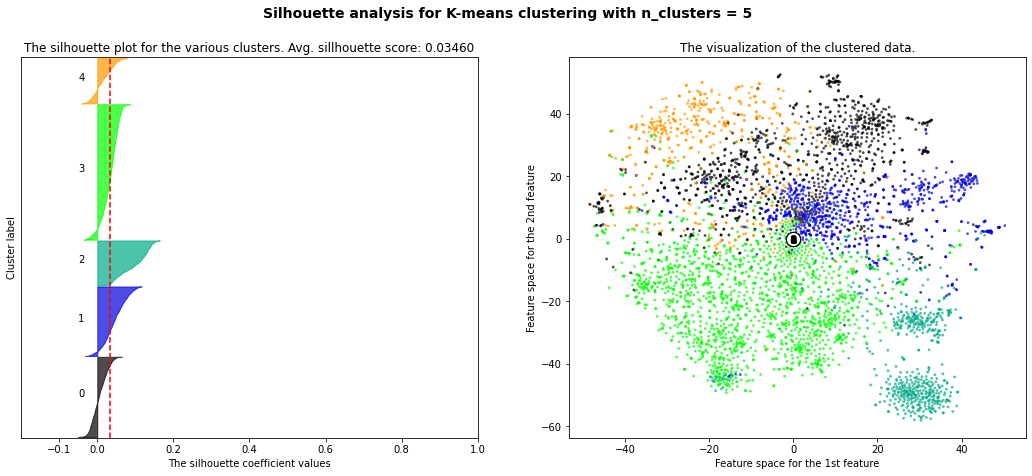

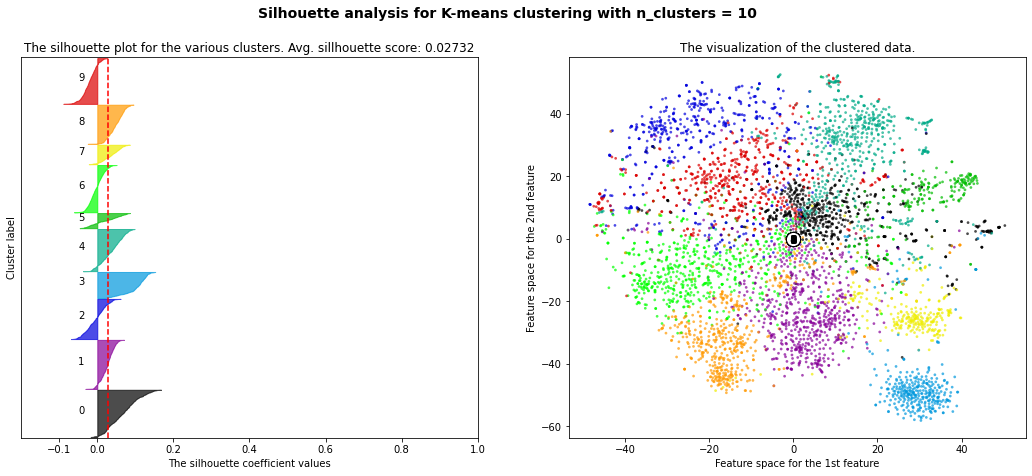

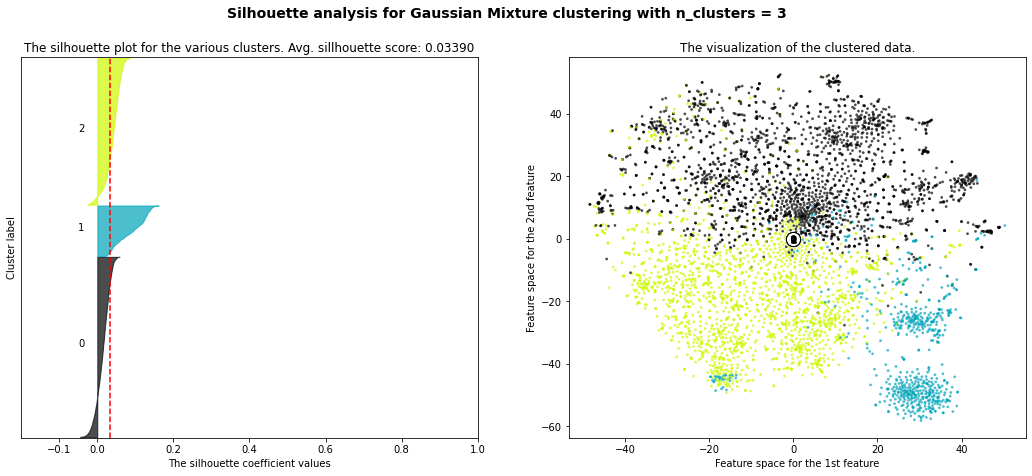

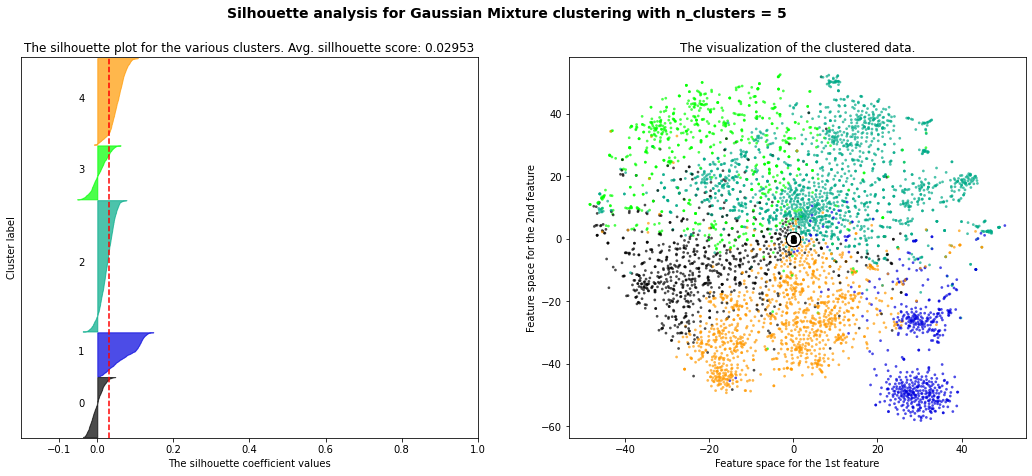

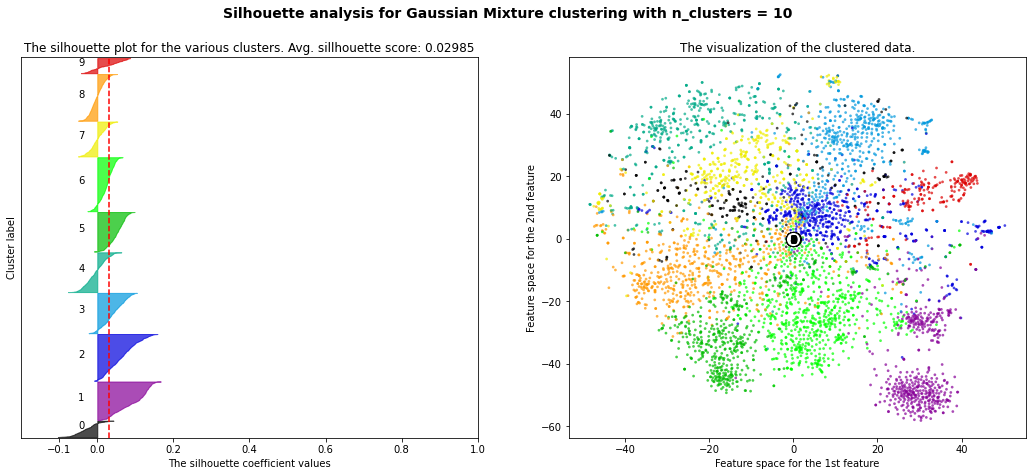

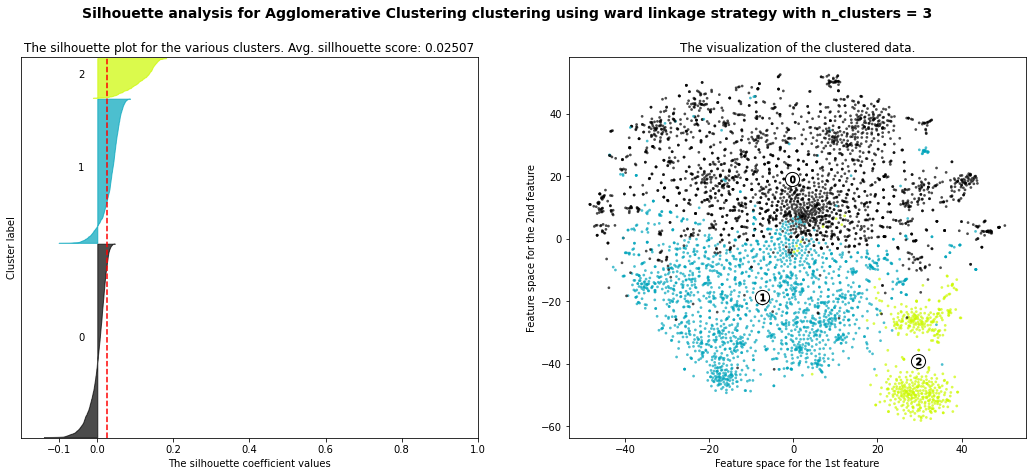

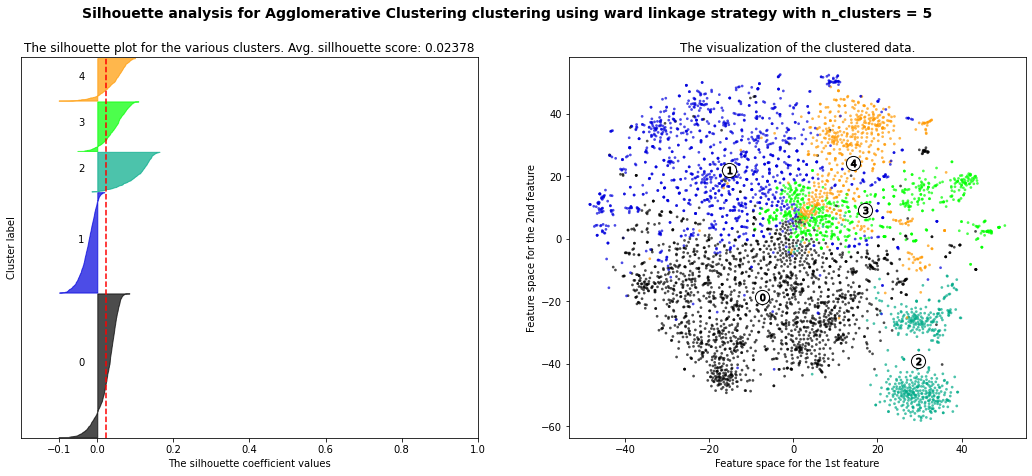

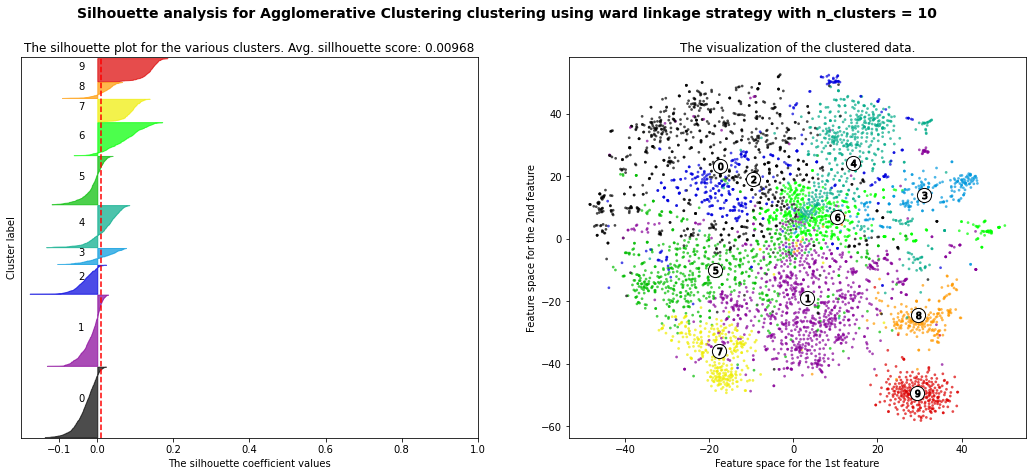

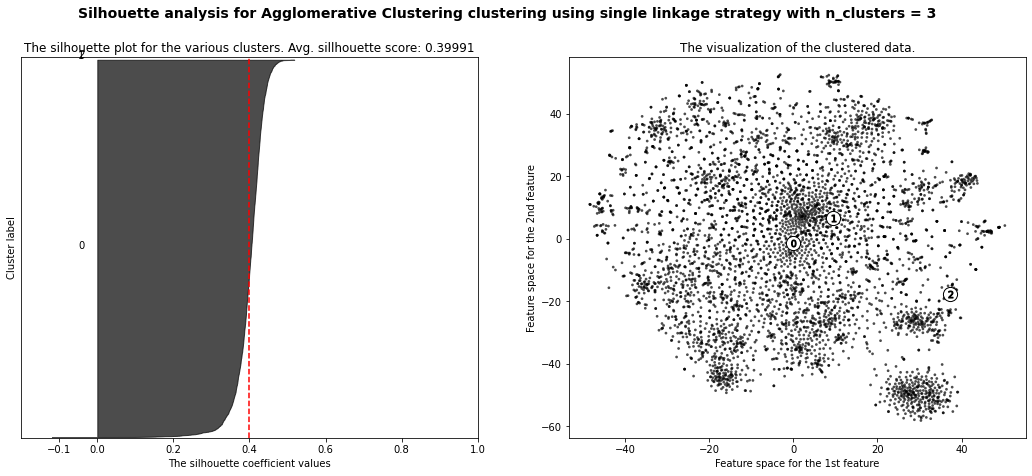

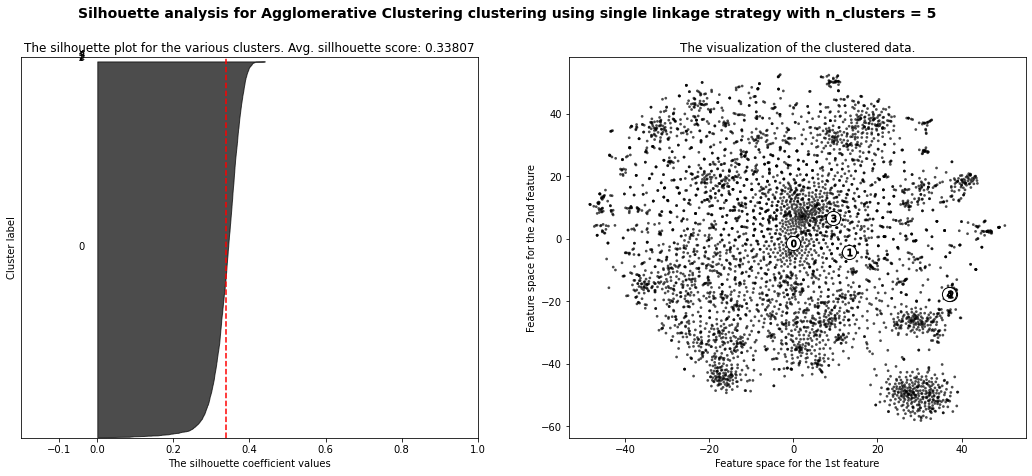

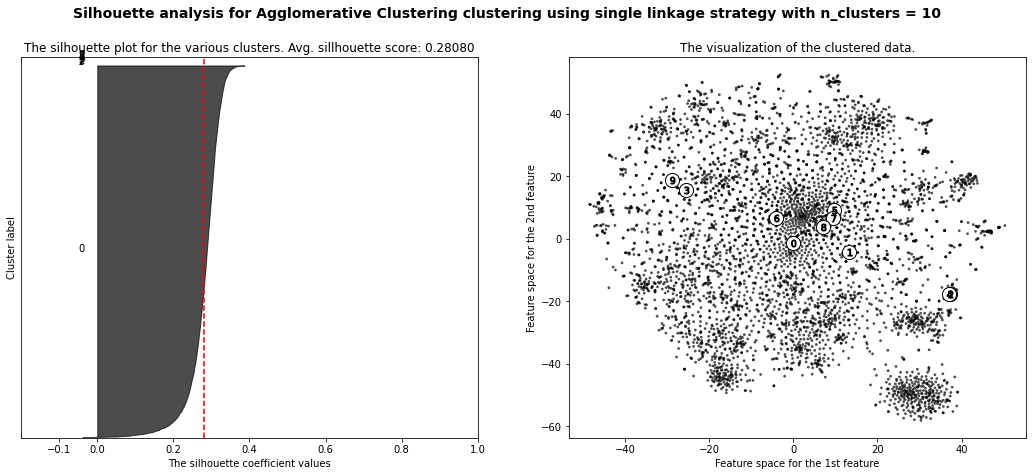

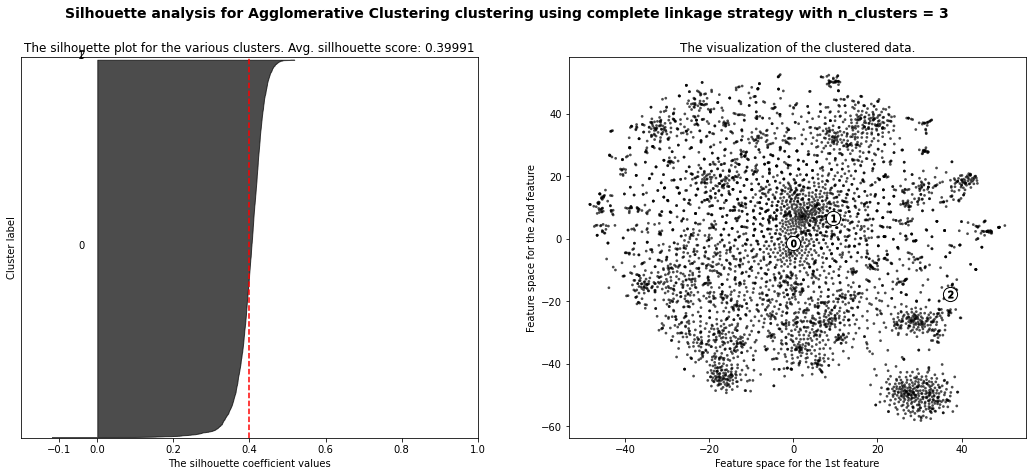

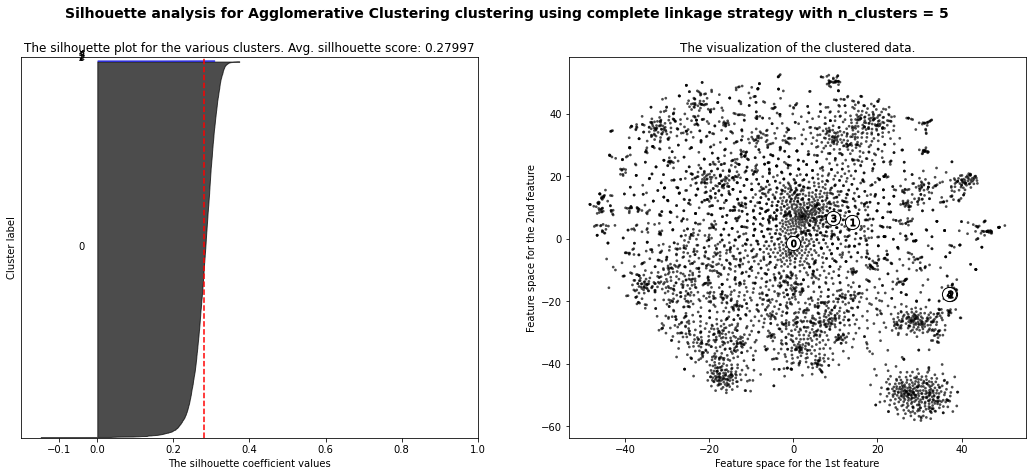

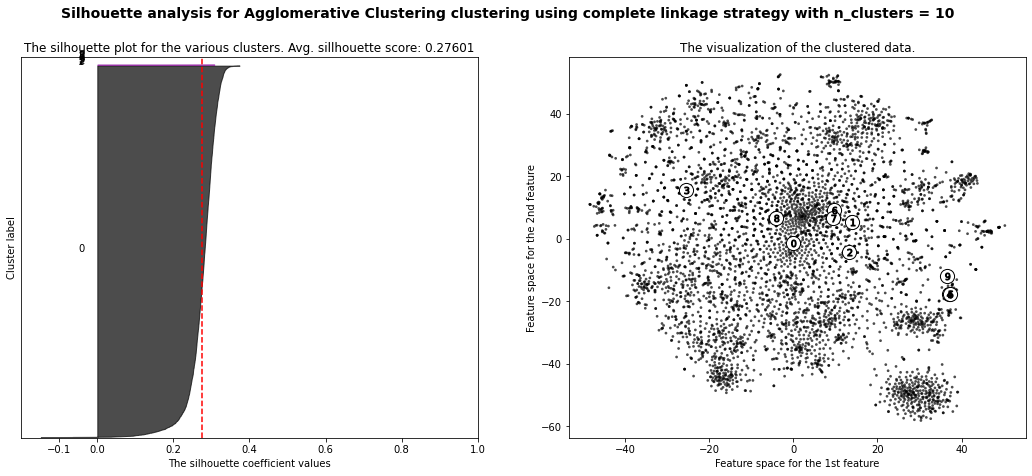

In [100]:
range_n_clusters = [3, 5, 10]
methods = ['K-means', 'Gaussian Mixture', 'Agglomerative Clustering']
linkage_strategies = ["ward", "single", "complete"]

results = []

for method in methods:
    for linkage_strategy in linkage_strategies:
        for n_clusters in range_n_clusters:
            # Initialize the clusterer with n_clusters value and a random generator
            # seed of 10 for reproducibility.
            clusterer, cluster_labels = cluster(X, method, n_clusters, linkage_strategy)

            silhouette_avg = silhouette_score(X, cluster_labels)
            if method == "Agglomerative Clustering":
                print("For n_clusters = {0:2} (linkage strategy: {1}) the average silhouette_score is: {2}".format(n_clusters, linkage_strategy, silhouette_avg))
            else:
                print("For n_clusters = {0:2} the average silhouette_score is: {1}".format(n_clusters, silhouette_avg))
            
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            plot_clusters(X_embedded, cluster_labels, n_clusters, method, sample_silhouette_values)

            results.append({
                "method" : method,
                "n_clusters": n_clusters,
                "linkage_strategy": linkage_strategy,
                "silhouette_score": silhouette_avg
            })
        if method != "Agglomerative Clustering":
            break
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame.from_records(results)

In [107]:
df

,method,n_clusters,linkage_strategy,silhouette_score
0,K-means,3,ward,0.033828
1,K-means,5,ward,0.034595
2,K-means,10,ward,0.027321
3,Gaussian Mixture,3,ward,0.033628
4,Gaussian Mixture,5,ward,0.029111
5,Gaussian Mixture,10,ward,0.031097
6,Agglomerative Clustering,3,ward,0.023153
7,Agglomerative Clustering,5,ward,0.025687
8,Agglomerative Clustering,10,ward,0.008494
9,Agglomerative Clustering,3,single,0.399906


# Task 3

Perform the Principal Component Analysis on the data (use the function `sklearn.decomposition.PCA`). Visualise the data transformed into the first two principal components. Try to guess what features of words are represented by the first two components. Run the K-Means, Gaussian-Mixture, and Aglomerative clustering on the data transformed into the first two PCA componens. Compute the Silhouette coeficients and find the best number of clusters. Why the silhouette coeficients are so different from those in Task 2?

In [102]:
from sklearn.decomposition import PCA

In [105]:
pca = PCA(n_components=2)
X_PCA_transformed = pca.fit_transform(X)

(5000, 2)


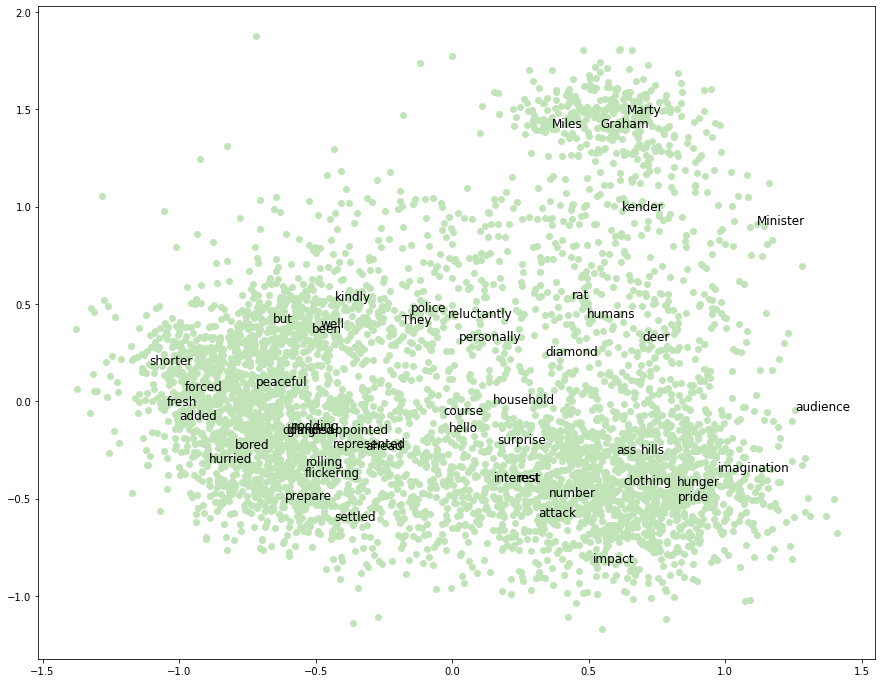

In [136]:
plot_word_embeddings(X_PCA_transformed, seed=42)